In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.mstats import mquantiles

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error


In [41]:
df = pd.read_excel(r'C:\Users\akrit\Downloads\XYZ_Apparel_Orders.xlsx')

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order type,Customer Order Code,Value,Currency,Items,Route
0,17.08.2009,17.02.2011,PL,PARKA03,Winter Parka,VO,ORD8880,461.01,USD,67,R02
1,21.02.2009,21.09.2009,NO,PARKA04,Lightweight Parka,VO,ORD5840,463.45,USD,74,R09
2,18.07.2010,16.03.2010,FI,PARKA02,Eco-friendly Parka,VO,ORD2581,88.16,EUR,72,R06
3,17.05.2010,03.02.2010,RU,PARKA05,Warm Parka,VO,ORD4586,349.80,USD,24,R05
4,03.04.2010,27.03.2009,PL,PARKA04,Winter Parka,VO,ORD2841,193.38,USD,49,R09
...,...,...,...,...,...,...,...,...,...,...,...
2416,12.05.2010,23.02.2009,ES,PARKA02,Durable Parka,VO,ORD4160,249.49,USD,39,R07
2417,30.10.2010,25.03.2011,NO,PARKA01,Durable Parka,VO,ORD9008,235.01,RUB,2,R03
2418,10.02.2011,21.05.2009,PL,PARKA01,Eco-friendly Parka,VO,ORD5614,114.64,USD,14,R01
2419,29.07.2010,17.10.2010,SE,PARKA01,Lightweight Parka,VO,ORD5369,378.49,USD,98,R09


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order Date               2421 non-null   object 
 1   Requested Delivery Date  2421 non-null   object 
 2   Customer Country Code    2421 non-null   object 
 3   Product Code             2421 non-null   object 
 4   Description              2421 non-null   object 
 5   Order type               2421 non-null   object 
 6   Customer Order Code      2421 non-null   object 
 7   Value                    2421 non-null   float64
 8   Currency                 2421 non-null   object 
 9   Items                    2421 non-null   int64  
 10  Route                    2421 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.2+ KB


In [43]:
df.describe()

,Value,Items
count,2421.000000,2421.000000
mean,273.153412,49.382487
std,131.216703,29.088124
min,50.000000,1.000000
25%,157.470000,24.000000
50%,275.260000,48.000000
75%,389.940000,75.000000
max,499.590000,100.000000


In [44]:
# replace null values into 0 

# df.fillna(0, inplace=True)
# df.replace(r'\N', 0, inplace=True)

In [45]:
# look for if there's anything with Value greater than 0 
# remove rows with Value smaller than 0 

# negative_rows = df[df['Value'] < 0]

# df = df[df['Value'] >= 0]

In [46]:
# rename column names for easier reference 

# df.rename(columns={'order_date': 'Order Date', 'requested_delivery_date': 'Requested Delivery Date', 'order_type': 'Order Type', 'value': 'Value', 'Curr': 'Currency', 'items': 'Items'}, inplace=True)

In [47]:
# Tranform data type to date

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

df['Delivery Year'] = df['Requested Delivery Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month

In [48]:
df.dtypes

Order Date                 datetime64[ns]
Requested Delivery Date    datetime64[ns]
Customer Country Code              object
Product Code                       object
Description                        object
Order type                         object
Customer Order Code                object
Value                             float64
Currency                           object
Items                               int64
Route                              object
Order Year                          int32
Order Month                         int32
Delivery Year                       int32
Delivery Month                      int32
dtype: object

In [49]:
# convert Items into type - int 
# df['Items'] = df['Items'].astype(int)

#### First Uncertainty: Time series analysis on the number of distinct orders per month 

In [50]:
# Extract year and month for grouping
df['YearMonth'] = df['Order Date'].dt.to_period('M')

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth
0,2009-08-17,2011-02-17,PL,PARKA03,Winter Parka,VO,ORD8880,461.01,USD,67,R02,2009,8,2011,2,2009-08
1,2009-02-21,2009-09-21,NO,PARKA04,Lightweight Parka,VO,ORD5840,463.45,USD,74,R09,2009,2,2009,9,2009-02
2,2010-07-18,2010-03-16,FI,PARKA02,Eco-friendly Parka,VO,ORD2581,88.16,EUR,72,R06,2010,7,2010,3,2010-07
3,2010-05-17,2010-02-03,RU,PARKA05,Warm Parka,VO,ORD4586,349.80,USD,24,R05,2010,5,2010,2,2010-05
4,2010-04-03,2009-03-27,PL,PARKA04,Winter Parka,VO,ORD2841,193.38,USD,49,R09,2010,4,2009,3,2010-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2010-05-12,2009-02-23,ES,PARKA02,Durable Parka,VO,ORD4160,249.49,USD,39,R07,2010,5,2009,2,2010-05
2417,2010-10-30,2011-03-25,NO,PARKA01,Durable Parka,VO,ORD9008,235.01,RUB,2,R03,2010,10,2011,3,2010-10
2418,2011-02-10,2009-05-21,PL,PARKA01,Eco-friendly Parka,VO,ORD5614,114.64,USD,14,R01,2011,2,2009,5,2011-02
2419,2010-07-29,2010-10-17,SE,PARKA01,Lightweight Parka,VO,ORD5369,378.49,USD,98,R09,2010,7,2010,10,2010-07


In [51]:
# Group transaction into monthly information -- with distinct order number

monthly_order = df.groupby('YearMonth').agg({'Customer Order Code': 'count'}).reset_index()

monthly_order = monthly_order.sort_values(by='YearMonth')

In [52]:
monthly_order

,YearMonth,Customer Order Code
0,2009-01,49
1,2009-02,51
2,2009-03,66
3,2009-04,68
4,2009-05,72
5,2009-06,78
6,2009-07,73
7,2009-08,67
8,2009-09,61
9,2009-10,72


In [53]:
monthly_order.rename(columns = {"Customer Order Code": "Count of Distinct Order"}, inplace = True)

monthly_order

,YearMonth,Count of Distinct Order
0,2009-01,49
1,2009-02,51
2,2009-03,66
3,2009-04,68
4,2009-05,72
5,2009-06,78
6,2009-07,73
7,2009-08,67
8,2009-09,61
9,2009-10,72


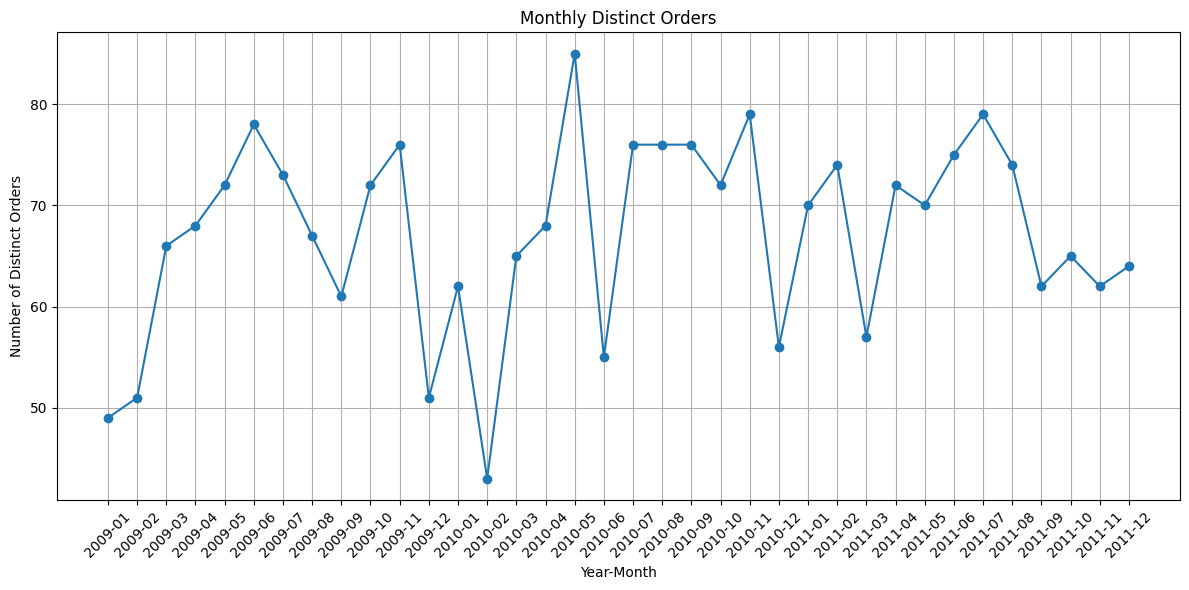

In [54]:
# Convert YearMonth to a string format for plotting
monthly_order.reset_index(inplace=True)
monthly_order['YearMonthStr'] = monthly_order['YearMonth'].dt.strftime('%Y-%m')

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_order['YearMonthStr'], monthly_order['Count of Distinct Order'], marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title('Monthly Distinct Orders')
plt.xlabel('Year-Month')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
monthly_order

,index,YearMonth,Count of Distinct Order,YearMonthStr
0,0,2009-01,49,2009-01
1,1,2009-02,51,2009-02
2,2,2009-03,66,2009-03
3,3,2009-04,68,2009-04
4,4,2009-05,72,2009-05
5,5,2009-06,78,2009-06
6,6,2009-07,73,2009-07
7,7,2009-08,67,2009-08
8,8,2009-09,61,2009-09
9,9,2009-10,72,2009-10


In [56]:
monthly_order = monthly_order.drop(columns = ['index'])


monthly_order

,YearMonth,Count of Distinct Order,YearMonthStr
0,2009-01,49,2009-01
1,2009-02,51,2009-02
2,2009-03,66,2009-03
3,2009-04,68,2009-04
4,2009-05,72,2009-05
5,2009-06,78,2009-06
6,2009-07,73,2009-07
7,2009-08,67,2009-08
8,2009-09,61,2009-09
9,2009-10,72,2009-10


In [57]:
# Perform ADF test on the 'Distinct Orders' series
adf_result = adfuller(monthly_order['Count of Distinct Order'])

# Extract results
adf_stat = adf_result[0]  # Test statistic
p_value = adf_result[1]   # p-value
critical_values = adf_result[4]  # Critical values

# Print the results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:", critical_values)

# Here, the p-value is higher 0.05, indicating that the series is not stationary 
# The time series here exhibits trends, seasonality or other non-stationary behaviours 

ADF Statistic: -1.7689998840158445
p-value: 0.3959573337969515
Critical Values: {'1%': np.float64(-3.7112123008648155), '5%': np.float64(-2.981246804733728), '10%': np.float64(-2.6300945562130176)}


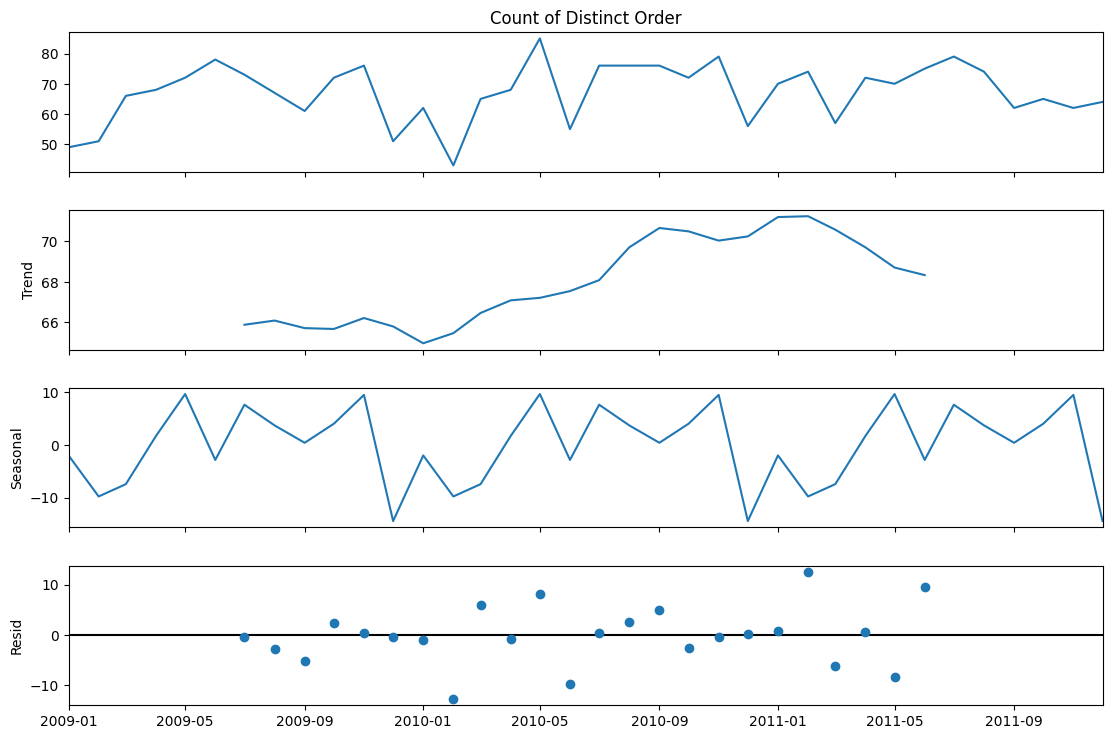

In [58]:
# Time Series Decomposition
# Decompose the time series into trend, seasonality, and residuals
monthly_order['YearMonth'] = monthly_order['YearMonth'].dt.to_timestamp()

# Set 'YearMonth' as the index
monthly_order.set_index('YearMonth', inplace=True)

decomposition = seasonal_decompose(monthly_order['Count of Distinct Order'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


# showing a clear seasonal pattern with peaks and troughs in the seasonal chart -- a repeating pattern 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

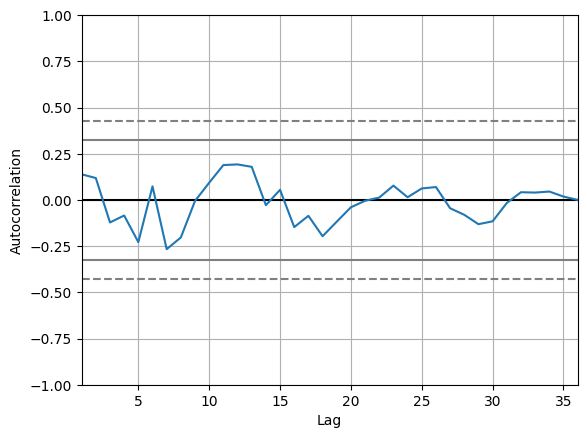

In [59]:
pd.plotting.autocorrelation_plot(monthly_order['Count of Distinct Order'])

# low autocorrelation -- current values of the series do not have much dependence on its past values 

In [60]:
monthly_order

,Count of Distinct Order,YearMonthStr
YearMonth,,
2009-01-01,49,2009-01
2009-02-01,51,2009-02
2009-03-01,66,2009-03
2009-04-01,68,2009-04
2009-05-01,72,2009-05
2009-06-01,78,2009-06
2009-07-01,73,2009-07
2009-08-01,67,2009-08
2009-09-01,61,2009-09


In [61]:
# Define the SARIMA model - with seasonality considered
sarima_model = SARIMAX(
    monthly_order['Count of Distinct Order'],
    order=(2, 1, 2),  # ARIMA(p, d, q) - suggesting current value depends on previous 2 observations, and is linear trend 
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, s) where s=12 for monthly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False,
)
# Fit the model
sarima_fit = sarima_model.fit(disp=False)


c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [62]:
# Forecast for next 2 months

forecast_2_months = sarima_fit.get_forecast(steps=2)
forecast_2_values = forecast_2_months.predicted_mean
forecast_2_conf_int = forecast_2_months.conf_int()

In [63]:
forecast_2_values

2012-01-01    71.651637
2012-02-01    64.498044
Freq: MS, Name: predicted_mean, dtype: float64

In [64]:
# Forecast for next 5 months

forecast_5_months = sarima_fit.get_forecast(steps=5)
forecast_5_values = forecast_5_months.predicted_mean
forecast_5_conf_int = forecast_5_months.conf_int()

In [65]:
forecast_5_values

2012-01-01    71.651637
2012-02-01    64.498044
2012-03-01    53.227224
2012-04-01    64.397999
2012-05-01    69.097814
Freq: MS, Name: predicted_mean, dtype: float64

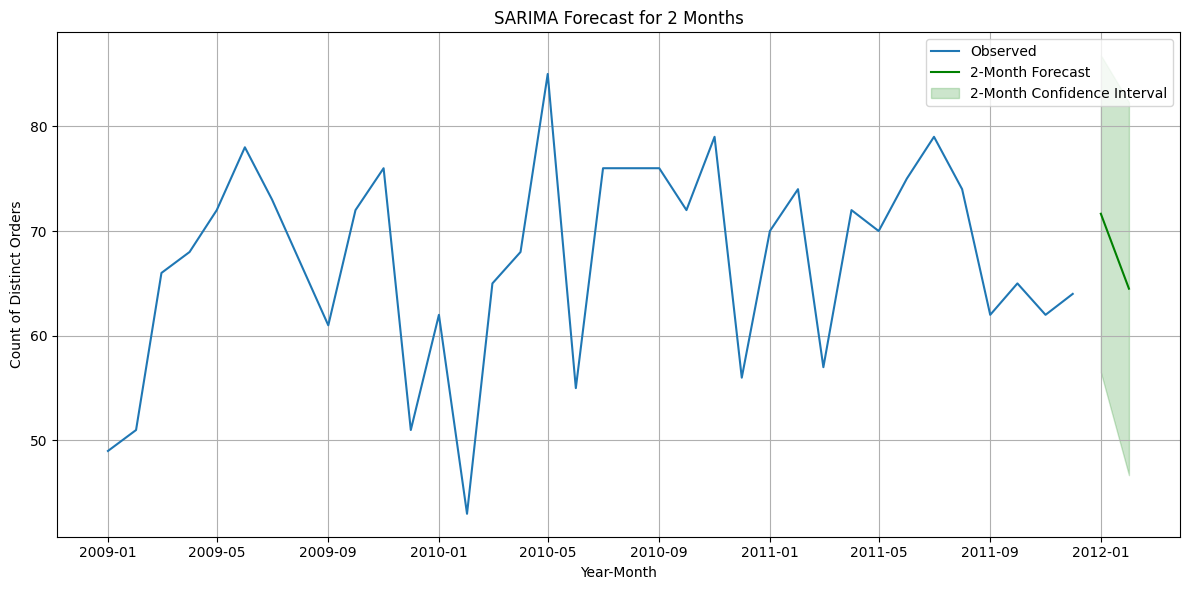

In [66]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_order.index, monthly_order['Count of Distinct Order'], label='Observed')
plt.plot(forecast_2_values.index, forecast_2_values, color='green', label='2-Month Forecast')
plt.fill_between(
    forecast_2_conf_int.index,
    forecast_2_conf_int.iloc[:, 0],
    forecast_2_conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='2-Month Confidence Interval',
)

plt.title('SARIMA Forecast for 2 Months')
plt.xlabel('Year-Month')
plt.ylabel('Count of Distinct Orders')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

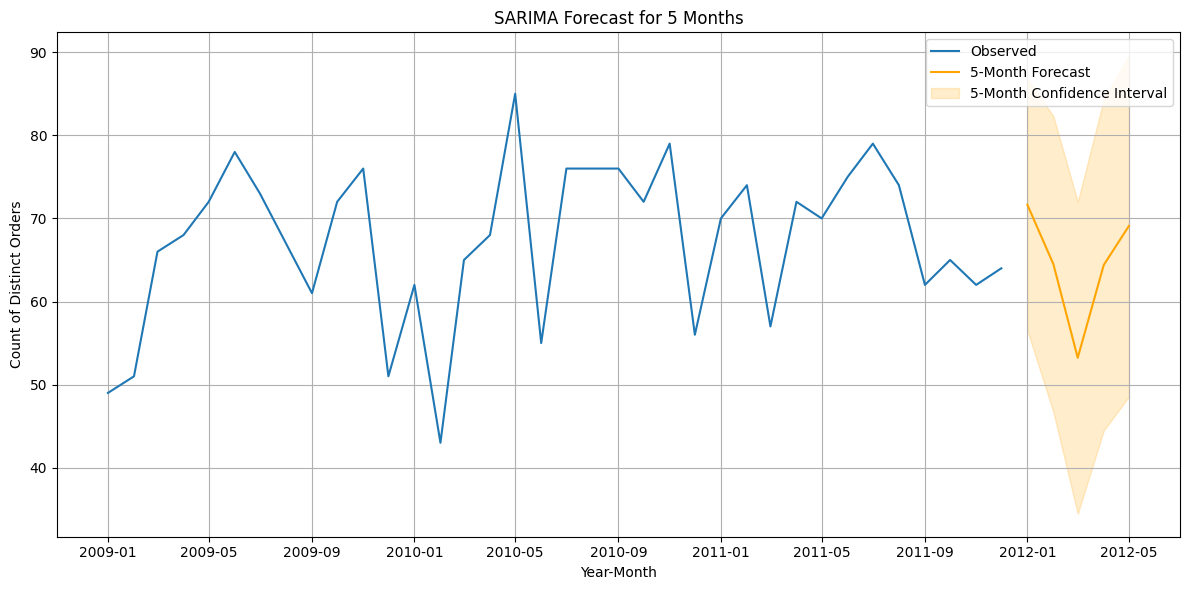

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_order.index, monthly_order['Count of Distinct Order'], label='Observed')
plt.plot(forecast_5_values.index, forecast_5_values, color='orange', label='5-Month Forecast')
plt.fill_between(
    forecast_5_conf_int.index,
    forecast_5_conf_int.iloc[:, 0],
    forecast_5_conf_int.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='5-Month Confidence Interval',
)
plt.title('SARIMA Forecast for 5 Months')
plt.xlabel('Year-Month')
plt.ylabel('Count of Distinct Orders')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [68]:
# Now - test if the model works well
# Split the data into training and testing sets
train_size = int(len(monthly_order) * 0.8)
train_data = monthly_order['Count of Distinct Order'][:train_size]
test_data = monthly_order['Count of Distinct Order'][train_size:]

In [69]:
# Fit the SARIMA model on training data
sarima_model = SARIMAX(
    train_data,
    order=(2, 1, 2),  # ARIMA(p, d, q)
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, s) where s=12 for monthly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_fit = sarima_model.fit(disp=False)

c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\akrit\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1233: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /

In [70]:
# Forecast for the testing period
forecast_test = sarima_fit.get_forecast(steps=len(test_data))
forecast_test_values = forecast_test.predicted_mean
forecast_test_conf_int = forecast_test.conf_int()

In [71]:
# Compute MAPE for the testing period
mape = mean_absolute_percentage_error(test_data, forecast_test_values)

mape

# Here, a MAPE of 18.46% is considered a good measure for the model 

np.float64(0.1846981311496545)

#### Second Uncertainty: Which product would be demanded 

In [72]:
# Adding Seasonal categorical variable

def month_to_season(month):
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:
        return 4  # Winter 
    

df["Order Season"] = df['Order Month'].apply(month_to_season)
df['Delivery Season'] = df['Delivery Month'].apply(month_to_season)

In [73]:
df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth,Order Season,Delivery Season
0,2009-08-17,2011-02-17,PL,PARKA03,Winter Parka,VO,ORD8880,461.01,USD,67,R02,2009,8,2011,2,2009-08,2,4
1,2009-02-21,2009-09-21,NO,PARKA04,Lightweight Parka,VO,ORD5840,463.45,USD,74,R09,2009,2,2009,9,2009-02,4,3
2,2010-07-18,2010-03-16,FI,PARKA02,Eco-friendly Parka,VO,ORD2581,88.16,EUR,72,R06,2010,7,2010,3,2010-07,2,1
3,2010-05-17,2010-02-03,RU,PARKA05,Warm Parka,VO,ORD4586,349.80,USD,24,R05,2010,5,2010,2,2010-05,1,4
4,2010-04-03,2009-03-27,PL,PARKA04,Winter Parka,VO,ORD2841,193.38,USD,49,R09,2010,4,2009,3,2010-04,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2010-05-12,2009-02-23,ES,PARKA02,Durable Parka,VO,ORD4160,249.49,USD,39,R07,2010,5,2009,2,2010-05,1,4
2417,2010-10-30,2011-03-25,NO,PARKA01,Durable Parka,VO,ORD9008,235.01,RUB,2,R03,2010,10,2011,3,2010-10,3,1
2418,2011-02-10,2009-05-21,PL,PARKA01,Eco-friendly Parka,VO,ORD5614,114.64,USD,14,R01,2011,2,2009,5,2011-02,4,1
2419,2010-07-29,2010-10-17,SE,PARKA01,Lightweight Parka,VO,ORD5369,378.49,USD,98,R09,2010,7,2010,10,2010-07,2,3


In [74]:
df['Unit Price'] = df['Value'] / df['Items']

df

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month,YearMonth,Order Season,Delivery Season,Unit Price
0,2009-08-17,2011-02-17,PL,PARKA03,Winter Parka,VO,ORD8880,461.01,USD,67,R02,2009,8,2011,2,2009-08,2,4,6.880746
1,2009-02-21,2009-09-21,NO,PARKA04,Lightweight Parka,VO,ORD5840,463.45,USD,74,R09,2009,2,2009,9,2009-02,4,3,6.262838
2,2010-07-18,2010-03-16,FI,PARKA02,Eco-friendly Parka,VO,ORD2581,88.16,EUR,72,R06,2010,7,2010,3,2010-07,2,1,1.224444
3,2010-05-17,2010-02-03,RU,PARKA05,Warm Parka,VO,ORD4586,349.80,USD,24,R05,2010,5,2010,2,2010-05,1,4,14.575000
4,2010-04-03,2009-03-27,PL,PARKA04,Winter Parka,VO,ORD2841,193.38,USD,49,R09,2010,4,2009,3,2010-04,1,1,3.946531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2010-05-12,2009-02-23,ES,PARKA02,Durable Parka,VO,ORD4160,249.49,USD,39,R07,2010,5,2009,2,2010-05,1,4,6.397179
2417,2010-10-30,2011-03-25,NO,PARKA01,Durable Parka,VO,ORD9008,235.01,RUB,2,R03,2010,10,2011,3,2010-10,3,1,117.505000
2418,2011-02-10,2009-05-21,PL,PARKA01,Eco-friendly Parka,VO,ORD5614,114.64,USD,14,R01,2011,2,2009,5,2011-02,4,1,8.188571
2419,2010-07-29,2010-10-17,SE,PARKA01,Lightweight Parka,VO,ORD5369,378.49,USD,98,R09,2010,7,2010,10,2010-07,2,3,3.862143


In [75]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Order Year', 'Order Month',
       'Delivery Year', 'Delivery Month', 'YearMonth', 'Order Season',
       'Delivery Season', 'Unit Price'],
      dtype='object')

In [76]:
# Features and target
features = ['Customer Country Code', 'Order type', 'Customer Order Code',
            'Value', 'Items', 'Route', 'Order Year',
            'Delivery Year', 'Order Season', 'Delivery Season', 'Unit Price']
X = df[features]
y = df['Product Code']

# Encode categorical variables using one-hot encoding or label encoding
categorical_columns = ['Customer Country Code', 'Order type', 'Customer Order Code', 'Route']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

numerical_columns = ['Value', 'Items', 'Order Year', 'Delivery Year', 'Unit Price']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)

logloss = log_loss(y_test, probs)
print(f'Log Loss: {logloss:.4f}')

# Convert probabilities into a DataFrame with product codes as columns
probs_df = pd.DataFrame(probs, columns=label_encoder.classes_)

# Add a column to indicate the most likely product for each instance
probs_df['Predicted_Product'] = probs_df.idxmax(axis=1)

# Display the first few rows of the probability DataFrame
probs_df.head()

Log Loss: 1.6546


,PARKA01,PARKA02,PARKA03,PARKA04,PARKA05,Predicted_Product
0,0.24,0.26,0.11,0.21,0.18,PARKA02
1,0.21,0.37,0.13,0.14,0.15,PARKA02
2,0.26,0.22,0.17,0.23,0.12,PARKA01
3,0.18,0.20,0.25,0.26,0.11,PARKA04
4,0.11,0.27,0.09,0.15,0.38,PARKA05


In [78]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.21237113402061855


#### Third Uncertainty: What is the quantity demanded for each item in these orders 

In [79]:
# Group the data by 'Product Code' and calculate quantiles for 'Items' (quantity demanded)
grouped_quantiles = df.groupby('Product Code')['Items'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
)

# Convert the result to a DataFrame for better readability
quantiles_per_product = grouped_quantiles.apply(pd.Series)
quantiles_per_product.columns = ['25th Percentile', 'Median', '75th Percentile']

# Display the results
print(quantiles_per_product)

              25th Percentile  Median  75th Percentile
Product Code                                          
PARKA01                  20.2    47.0             76.0
PARKA02                  26.0    49.0             74.0
PARKA03                  23.0    48.0             73.3
PARKA04                  24.0    49.0             75.0
PARKA05                  24.0    48.0             77.0


In [80]:
# Group by 'Product Code' and 'Items' to calculate frequency
quantity_data = df.groupby(['Product Code', 'Items']).size().reset_index(name='Frequency')

# Calculate probabilities and cumulative probabilities for each Product Code
quantity_data['Probability'] = quantity_data.groupby('Product Code')['Frequency'].transform(lambda x: x / x.sum())
quantity_data['Cumulative Probability'] = quantity_data.groupby('Product Code')['Probability'].cumsum()

# Define intervals for random numbers
quantity_data['Interval of Random Numbers'] = (
    quantity_data.groupby('Product Code')['Cumulative Probability']
    .shift(fill_value=0).round(2).astype(str) +
    " through " +
    quantity_data['Cumulative Probability'].round(2).astype(str)
)

# Display the result using a simple print statement
print(quantity_data)

# Alternatively, save the result to a CSV file
quantity_data.to_csv("quantity_demanded_probabilities.csv", index=False)

    Product Code  Items  Frequency  Probability  Cumulative Probability  \
0        PARKA01      1          6     0.012024                0.012024   
1        PARKA01      2          3     0.006012                0.018036   
2        PARKA01      3          4     0.008016                0.026052   
3        PARKA01      4          3     0.006012                0.032064   
4        PARKA01      5         10     0.020040                0.052104   
..           ...    ...        ...          ...                     ...   
491      PARKA05     96          5     0.010917                0.960699   
492      PARKA05     97          3     0.006550                0.967249   
493      PARKA05     98          4     0.008734                0.975983   
494      PARKA05     99          6     0.013100                0.989083   
495      PARKA05    100          5     0.010917                1.000000   

    Interval of Random Numbers  
0             0.0 through 0.01  
1            0.01 through 0.02  


#### Fourth Uncertainty: What is the demand lead time of these orders (ie., time elapsed from the instant when an order is received until its delivery)

In [81]:
# Group the data by 'Customer Order Code' and calculate quantiles for 'Lead Time (days)'
grouped_lead_time_quantiles = df.groupby('Customer Order Code')['Lead Time (days)'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
)

# Convert the result to a DataFrame for better readability
quantiles_per_order = grouped_lead_time_quantiles.apply(pd.Series)
quantiles_per_order.columns = ['25th Percentile', 'Median', '75th Percentile']

# Display the results
print(quantiles_per_order)

KeyError: 'Column not found: Lead Time (days)'

In [ ]:
# Group by lead time and calculate frequencies
lead_time_data = df['Lead Time (days)'].value_counts().reset_index()
lead_time_data.columns = ['Reorder Lead Time', 'Frequency']
lead_time_data = lead_time_data.sort_values(by='Reorder Lead Time').reset_index(drop=True)

# Calculate probabilities and cumulative probabilities
lead_time_data['Probability'] = lead_time_data['Frequency'] / lead_time_data['Frequency'].sum()
lead_time_data['Cumulative Probability'] = lead_time_data['Probability'].cumsum()

# Define intervals for random numbers
lead_time_data['Interval of Random Numbers'] = (
    lead_time_data['Cumulative Probability'].shift(fill_value=0).round(2).astype(str) +
    " through " +
    lead_time_data['Cumulative Probability'].round(2).astype(str)
)

# Display the resulting table
print(lead_time_data)

KeyError: 'Lead Time (days)'